In [6]:
# import libraries
import numpy as np 
import pandas as pd  
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [7]:
# read data from csv file (columns TITLE and CATEGORY)

data = pd.read_csv('C:/Users/sumud/Documents/AI/attempt2/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [8]:
# print the item count for each category
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [9]:
# define the number of items per class - keep it a constant
items_per_cat = 45000
# shuffle the data set
shufds = data.reindex(np.random.permutation(data.index))

# for each category, get items to match items_per_cat
e = shufds[shufds['CATEGORY'] == 'e'][:items_per_cat]
b = shufds[shufds['CATEGORY'] == 'b'][:items_per_cat]
t = shufds[shufds['CATEGORY'] == 't'][:items_per_cat]
m = shufds[shufds['CATEGORY'] == 'm'][:items_per_cat]

# contacenate the list again
concated = pd.concat([e,b,t,m], ignore_index=True)
# shuffle
concated = concated.reindex(np.random.permutation(concated.index))
# create a column for LABEL (keep default to 0)
concated['LABEL'] = 0

In [10]:
# one hot encoding (assign an index to each label)
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
# labels to categirical (4 classes)
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

113404    2
168188    3
7454      0
48950     1
83465     1
106306    2
4203      0
161538    3
124550    2
107009    2
Name: LABEL, dtype: int64
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [11]:
# tokanize the dataset
# maximum number of words to consider is 8000
max_number_of_words = 8000
# maximum length of a single sentence is 130 words (remain will be trimmed)
max_len = 130
tokenizer = Tokenizer(num_words=max_number_of_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Unique Tokens:', len(word_index))
# use pad sequnece to make all sentences same size
X = pad_sequences(sequences, maxlen=max_len)

Unique Tokens: 51800


In [12]:
# prepare train and test sets
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [13]:
# set number of epochs to 10
epochs = 10
# word embedding dimension
emb_dim = 128
# training batch size
batch_size = 256

labels[:2]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [14]:
# print the shapes of data sets
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# create the model
model = Sequential()
# add word embedding layer
model.add(Embedding(max_number_of_words, emb_dim, input_length=X.shape[1]))
# add a dropout layer (70%)
model.add(SpatialDropout1D(0.7))
# add LSTM layer
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
# add a dence layer with 4 outputs and softmax activation
model.add(Dense(4, activation='softmax'))
# compile the model with categorical_crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# print the model summary
print(model.summary())

((135000, 130), (135000, 4), (45000, 130), (45000, 4))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# train the model

history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


Instructions for updating:
Use tf.cast instead.
Train on 108000 samples, validate on 27000 samples
Epoch 1/10
108000/108000 [==============================] - 124s 1ms/step - loss: 0.8592 - acc: 0.6515 - val_loss: 0.3384 - val_acc: 0.8852
Epoch 2/10
108000/108000 [==============================] - 85s 787us/step - loss: 0.3914 - acc: 0.8656 - val_loss: 0.2664 - val_acc: 0.9083
Epoch 3/10
108000/108000 [==============================] - 86s 798us/step - loss: 0.3147 - acc: 0.8934 - val_loss: 0.2433 - val_acc: 0.9175
Epoch 4/10
108000/108000 [==============================] - 87s 802us/step - loss: 0.2781 - acc: 0.9061 - val_loss: 0.2353 - val_acc: 0.9194
Epoch 5/10
108000/108000 [==============================] - 87s 805us/step - loss: 0.2628 - acc: 0.9116 - val_loss: 0.2304 - val_acc: 0.9212
Epoch 6/10
108000/108000 [==============================] - 87s 804us/step - loss: 0.2455 - acc: 0.9176 - val_loss: 0.2279 - val_acc: 0.9231
Epoch 7/10
108000/108000 [==============================

In [16]:
# evaluate the model
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45000/45000 [==============================] - 31s 696us/step
Test set
  Loss: 0.224
  Accuracy: 0.923


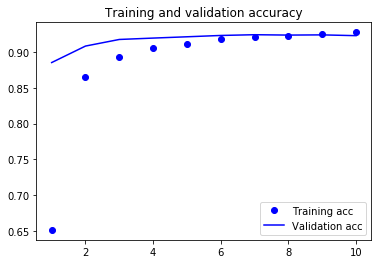

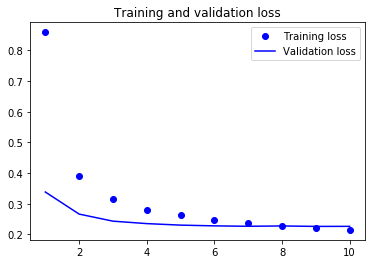

In [18]:
# generate the graph for training and validation accuracy, and training and validation loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
# try to predict a new text sentence
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[1.0663921e-04 5.1352254e-04 1.0853143e-04 9.9927133e-01]] health


In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("C:/Users/sumud/Documents/AI/attempt2/final/model-2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/Users/sumud/Documents/AI/attempt2/final/model-2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))